In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

In [3]:
import datetime as dt
import gmaps 
from config import gkey

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
#Measurement and Station table columns
print(f'Measurement table columns: {measurements.__table__.columns.keys()}')
print(f'Station table columns: {stations.__table__.columns.keys()}')


Measurement table columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station table columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [11]:
# Measurement table exploration
maxdate = session.query(func.max(measurements.date))[0][0]
mindate = session.query(func.min(measurements.date))[0][0]
databaselength = session.query(func.count(measurements.date))[0][0]


print(f"Measurment table's most recent date: {maxdate}")
print(f"Measurment table's oldest date: {mindate}")
print(f"The table has {databaselength} records.")

Measurment table's most recent date: 2017-08-23
Measurment table's oldest date: 2010-01-01
The table has 19550 records.


In [12]:
# Casting the year, month, and day into integers 
# to be used in the query date variable
year = int(maxdate[:4])
month = int(maxdate[5:7])
day = int(maxdate[8:10])


In [54]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(year,month,day) - dt.timedelta(days=365)
prcp_at_station = "USC00519281"

# Design a query to retrieve the last 12 months of precipitation data
last12months = session.query(measurements.date,measurements.prcp).\
    filter(measurements.date > query_date).\
    filter(measurements.station == prcp_at_station).all()

# # Save the query results as a Pandas DataFrame,sort the df by date and set the index to the date column
df = pd.DataFrame(last12months).sort_values('date')
df = df.rename(columns={'prcp':'precipitation'})
df['date'] = pd.to_datetime(df.date)

x = df.date
y = df.precipitation



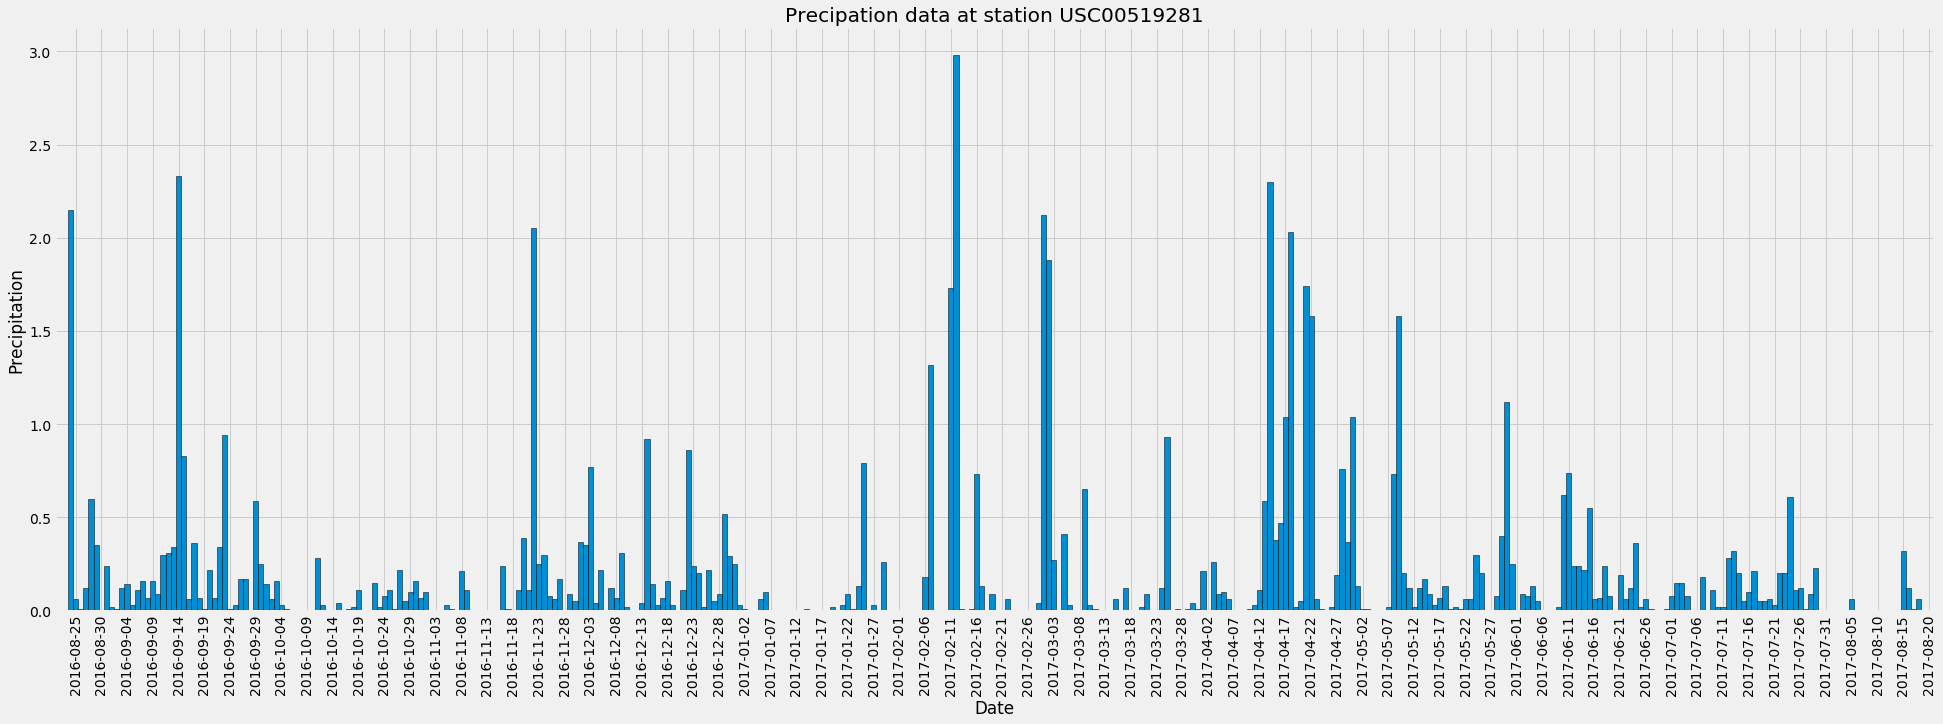

In [56]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.bar(x,y,width=1,edgecolor = 'black')
#plt.plot_date(x,y,fmt='-b',kind='bar')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f"Precipation data at station {prcp_at_station}")
plt.xlim(pd.to_datetime("2016-08-21"),pd.to_datetime("2017-08-21"))

plt.show()


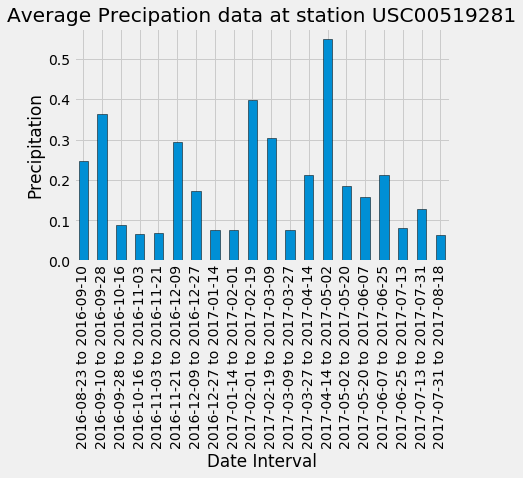

In [148]:
bins = pd.cut(x,20)

dfbins = pd.DataFrame({"date":x,"Precipitation":y,"bins":bins})

dfbins["left"] = [ x.left.strftime('%Y-%m-%d') for x in dfbins["bins"]]


dfbins["right"] = [ x.right.strftime('%Y-%m-%d') for x in dfbins["bins"]]
dfbins["right"]

dfbins['interval'] = dfbins['left'] + " to "  + dfbins['right']

dfbins2 = dfbins.groupby('interval').mean()
dfbins2.plot(kind='bar',legend=False,edgecolor='black')
plt.title(f"Average Precipation data at station {prcp_at_station}")
plt.ylabel("Precipitation")
plt.xlabel("Date Interval")
plt.grid(which='minor',axis='x')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,351.000000
mean,0.194416
std,0.411050
min,0.000000
25%,0.000000
50%,0.060000
75%,0.185000
max,2.980000


In [15]:
# Design a query to show how many stations are available in this dataset?
stationcode = session.query(measurements.station).group_by(measurements.station).all()
print(f'There are {len(stationcode)} stations')

There are 9 stations


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationcount = session.query(measurements.station,func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()

stationcount


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
#station with the most observations
stationmost = session.query(measurements.station,func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).first()
stationmost

('USC00519281', 2772)

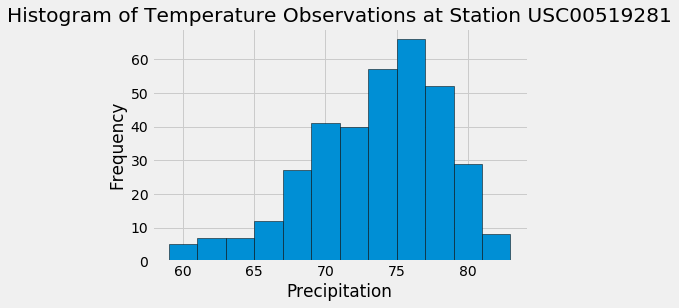

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = dt.date(year,month,day) - dt.timedelta(days=365)

last_12_months_temp_at_staion_most = session.query(measurements.date,measurements.tobs).\
    filter(measurements.date > query_date).\
    filter(measurements.station == stationmost[0]).all()

last12df = pd.DataFrame(last_12_months_temp_at_staion_most)

last12df.plot(kind='hist',bins=12,legend=False,edgecolor='black')
plt.xlabel("Precipitation")
plt.title(f"Histogram of Temperature Observations at Station {stationmost[0]}")
plt.show()


## Data manipulation for GMAPS


In [19]:
station_name_code = session.query(stations.station,stations.name).group_by(stations.name).all()
station_name_code


[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [20]:
station_df = pd.DataFrame(station_name_code)
station_df


,station,name
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00516128,"MANOA LYON ARBO 785.2, HI US"
4,USC00517948,"PEARL CITY, HI US"
5,USC00518838,"UPPER WAHIAWA 874.3, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00519397,"WAIKIKI 717.2, HI US"
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"


In [21]:
#Using Gmaps to plot locations of the stations
coordinates = session.query(stations.latitude,stations.longitude).all()

fig = gmaps.figure()


info_box_template = """
<dl>
<dt>Station code</dt><dd>{station}</dd>
<dt>Station name</dt><dd>{name}</dd>
</dl>
"""

# Store the DataFrame Row
station_info = [info_box_template.format(**row) for index, row in station_df.iterrows()]

#Add marker layer
markers = gmaps.marker_layer(coordinates,info_box_content=[f'Station Details: {info}' for info in station_info])
fig.add_layer(markers)
fig


Figure(layout=FigureLayout(height='420px'))

In [22]:
temp = session.query(measurements.date,measurements.tobs).\
    filter(measurements.date > query_date).\
    filter(measurements.station==stationmost[0]).all()

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowtemp = session.query(func.min(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).scalar()
hightemp = session.query(func.max(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).scalar()
avgtemp = session.query(func.avg(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).all()

print(f"Station {stationmost[0]} lowest recorded temperature was {lowtemp} Degrees F")
print(f"Station {stationmost[0]} highest recorded temperature was {hightemp} Degrees F")
print(f"Station {stationmost[0]} average recorded temperature was {round(avgtemp[0][0],2)} Degrees F")

Station USC00519281 lowest recorded temperature was 54.0 Degrees F
Station USC00519281 highest recorded temperature was 85.0 Degrees F
Station USC00519281 average recorded temperature was 71.66 Degrees F


## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).\
        filter(measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
